<a href="https://colab.research.google.com/github/DeepLearningInterpreter/occlusion_experiments/blob/master/colab_notebooks/Creating_heat_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction


With this notebook the occlusion experiments can be conducted with ease. The notebook is structured as follows. 

**First** you can choose whether you want to use SSD or Faster R-CNN (SSD is the quicker option of course). 

**The next few parts** are important but can be skipped or quickly glanced over. In these  parts, the repository is cloned to the cloud server, the necessary imports are taken care of, the model is loaded into memory, and some helpful functions are defined.

**The final part** of the notebook is the most interesting. Here, you can specify the images or interest and the parameters of the occlusion experiments. The resulting heat maps will be printed.

##Choose Your Model
Choose the meta architecture for which you want to conduct occlusion experiments.

In [0]:
#Set this variable equal to "SSD" or "FRCNN" (for Faster R-CNN)
meta_architecture = "SSD"

In [0]:
if meta_architecture == "SSD":
  MODEL_NAME = "SSD_ext_lrCyc"
  MODEL_TYPE = "SSD"
elif meta_architecture == "FRCNN":
  MODEL_NAME = "FRCNN_ext_lr3"
  MODEL_TYPE = "FRCNN"
else:
  raise ValueError(
      'The meta_architecture variable has to be set to either "SSD" or "FRCNN".'
  )

---------------------------------------------------------------------------
##Cloning the GitHub repository to the cloud server. 



In [0]:
#Downloading and installing git lfs
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 72 not upgraded.
Need to get 4,931 kB of archives.
After this operation, 12.3 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 2.6.1 [4,931 kB]
Fetched 4,931 kB in 1s (5,088 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/per

In [0]:
#Cloning repository. The exclude flag indicates that large files from the "training" and "evaluation" 
#subdirectories should not be downloaded
!git lfs clone https://github.com/DeepLearningInterpreter/occlusion_experiments.git --exclude="occlusion_experiments/main_content/multitude_of_possible_detectors/training, occlusion_experiments/main_content/multitude_of_possible_detectors/evaluation_outcomes"

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'occlusion_experiments'...
remote: Enumerating objects: 1998, done.
remote: Total 1998 (delta 0), reused 0 (delta 0), pack-reused 1998
Receiving objects: 100% (1998/1998), 184.87 MiB | 27.36 MiB/s, done.
Resolving deltas: 100% (277/277), done.
Checking out files: 100% (2209/2209), done.


In [0]:
import os
os.chdir("/content/occlusion_experiments/TF_object_detection_API_modified")
os.chdir("object_detection")
os.getcwd()

'/content/occlusion_experiments/TF_object_detection_API_modified/object_detection'

---------------------------------------------------------------------------------------------------------------------
##Imports and model preparation

In [0]:

# coding: utf-8

# # Imports
import csv
import math
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tensorflow as tf
import time

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import scipy.misc

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


In [0]:
#makes sure there is no printing output
%%capture 
        
#more imports
from object_detection.utils import label_map_util
from utils import visualization_utils as vis_util

In [0]:
os.chdir("/content/occlusion_experiments/TF_object_detection_API_modified")

In [0]:
%%capture
!python setup.py install

In [0]:
os.chdir("/content/occlusion_experiments/main_content")

In [0]:
from occlusion_help_funcs.help_funcs import load_image_into_numpy_array
from occlusion_help_funcs.help_funcs import compute_IoU

In [0]:
os.chdir("/content/occlusion_experiments/main_content/multitude_of_possible_detectors/frozen_models_for_detection/")
os.getcwd()
!ls -l *

FRCNN_ext_lr3:
total 50956
-rw-r--r-- 1 root root 52174566 Jan 24 08:16 frozen_inference_graph.pb
-rw-r--r-- 1 root root     3343 Jan 24 08:15 pipeline.config

SSD_ext_lrCyc:
total 106448
-rw-r--r-- 1 root root       77 Jan 24 08:15 checkpoint
-rw-r--r-- 1 root root      120 Jan 24 08:15 desktop.ini
-rw-r--r-- 1 root root 53966412 Jan 24 08:16 frozen_inference_graph.pb
-rw-r--r-- 1 root root 53367044 Jan 24 08:16 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root    18043 Jan 24 08:15 model.ckpt.index
-rw-r--r-- 1 root root  1616493 Jan 24 08:15 model.ckpt.meta
-rw-r--r-- 1 root root     7267 Jan 24 08:15 pipeline.config
drwxr-xr-x 3 root root     4096 Jan 24 08:15 saved_model


In [0]:
os.chdir("/content/occlusion_experiments/main_content")

# # Model preparation
path_to_model = '/content/occlusion_experiments/main_content/multitude_of_possible_detectors/frozen_models_for_detection/'

# Path to frozen detection graph. This is the actual model that is used for 
#the object detection.
PATH_TO_FROZEN_GRAPH = path_to_model + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data/main_data/', 'pistol_car_label_map.pbtxt')

#import pdb; pdb.set_trace()
#Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


#Loading label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, 
                                                         use_display_name=True)


end of imports and model preparation.

-------------------------------------------------------------
##Function definition


In [0]:
#NOTE: Untill now this scripts only works for an image that
#contains a single object.

def occlude_and_infer(image_path, real_box, stride, size, progressPrint=True):
  #Opens the image and converts image into numpy array.
  image = Image.open(image_path)
  image_np = load_image_into_numpy_array(image)
  image_sz = image_np.shape[0:2]
  
  #translating stride and size to pixel values
  image_surface = image_sz[0] * image_sz[1]
  size = int(round(np.sqrt(image_surface) * size))
  stride = int(round(size * stride))

  #import pdb; pdb.set_trace()
  
  #adjusting the bounding box coordinates for the image size
  real_box = real_box
  real_box =   [real_box[0]/image_sz[0], real_box[1]/image_sz[1],
                real_box[2]/image_sz[0], real_box[3]/image_sz[1]]

  #Random time measuring
  begin = time.time()
  toc = begin

  #confidence_map is the variable in which
  #the prediction confidence is saved if a pixel is occluded.
  confidence_map = np.zeros_like(image_np[:,:,0], dtype=float)
  #IoU_map is the variable in which
  #the prediction confidence is saved if a pixel is occluded.
  IoU_map = np.zeros_like(image_np[:,:,0], dtype=float)
  #The occlusion frequency map keeps track of how many times
  #each of the pixels has been occluded.
  occlusion_frequency_map = np.zeros_like(confidence_map)

  #Start a tensorflow session
  with detection_graph.as_default():
      with tf.Session() as sess:
          #Necessary model preparation--------------
          ops = tf.get_default_graph().get_operations()
          all_tensor_names = {output.name for op in ops for output in op.outputs}
          tensor_dict = {}
          for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes'
          ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
              tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)
          #end necessary model preparation------------

          #keeping track of progress
          iteration = 0
          vertical_steps = math.ceil((image_sz[0] + size - 2)/stride)
          horizontal_steps = math.ceil((image_sz[1] + size - 2)/stride)

          #Iterates each vertical occlusion box location.
          for j in range(vertical_steps):
              #Iterates each horizontal occlusion box location.
              for i in range(horizontal_steps):
                  iteration += 1
                  fraction_finished = iteration/(horizontal_steps*vertical_steps)
                  if progressPrint:
                    print("%.2f percent of the way!\n" % (fraction_finished * 100))

                  #more time measuring
                  tic = toc
                  toc = time.time()
                  secs_to_go =iteration*(toc-tic)/fraction_finished * (1 - fraction_finished)
                  if progressPrint:
                    print("At this pace, about", math.floor(secs_to_go/(60*60)), "h ", math.floor((secs_to_go%(60*60))/60),
                          "m %.0f s" % (secs_to_go%(60)), " to go!")

                  #The location of the occlusion box is
                  #indicated by x0, x1, y0, and y1, which are
                  #the left, right, top, and bottom borders
                  #of the box respectively.
                  x0 = i * stride - size + 1
                  x1 = x0 + size
                  y0 = j * stride - size + 1
                  y1 = y0 + size

                  x0 = max(0, x0)
                  y0 = max(0, y0)
                  
                  image_np_o = np.copy(image_np)

                  image_np_o[y0:y1, x0:x1, 0] = 163
                  image_np_o[y0:y1, x0:x1, 1] = 157
                  image_np_o[y0:y1, x0:x1, 2] = 152

                  #Start detecting on occluded image------
                  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                  image_np_expanded = np.expand_dims(image_np_o, axis=0)
                  image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

                  # Run inference
                  output_dict = sess.run(tensor_dict,
                                         feed_dict={image_tensor: image_np_expanded})

                  # all outputs are float32 numpy arrays, so convert types as appropriate
                  output_dict['num_detections'] = int(output_dict['num_detections'][0])
                  output_dict['detection_classes'] = output_dict[
                      'detection_classes'][0].astype(np.uint8)
                  output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                  output_dict['detection_scores'] = output_dict['detection_scores'][0]
                  #End detecting on occluded image-------------

                  highest = 0.2
                  detected_bool = False
                  #checking the IoU for every detection
                  for k in range(output_dict['num_detections']):
                      pred_box = output_dict['detection_boxes'][k]
                      IoU = compute_IoU(real_box, pred_box)
                      if IoU > highest:
                          highest = IoU
                          index = k
                          detected_bool = True

                  confidence = 0
                  if   (detected_bool and
                        output_dict['detection_classes'][index] == 1):
                      confidence = output_dict['detection_scores'][index]
                 
                  #fill up the confidence_map array and
                  #update occlusion_frequency_map
                  confidence_map[y0:y1, x0:x1] =  (confidence_map[y0:y1, x0:x1] + confidence)
                  IoU_map[y0:y1, x0:x1] =  (IoU_map[y0:y1, x0:x1] + highest*(highest>0.2))
                  occlusion_frequency_map[y0:y1, x0:x1] =   (occlusion_frequency_map[y0:y1, x0:x1]
                                                     + 1)
          #--------computing confidence and IoU on original image---------
          #Start detecting on UNoccluded image------
          # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
          image_np_expanded = np.expand_dims(image_np, axis=0)
          image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

          # Run inference
          output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: image_np_expanded})

          # all outputs are float32 numpy arrays, so convert types as appropriate
          output_dict['num_detections'] = int(output_dict['num_detections'][0])
          output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
          output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
          output_dict['detection_scores'] = output_dict['detection_scores'][0]
          
          #End detecting on UNoccluded image-------------
          highest = 0.2
          detected_bool = False
          #checking the IoU for every detection
          for k in range(output_dict['num_detections']):
              pred_box = output_dict['detection_boxes'][k]
              IoU = compute_IoU(real_box, pred_box)
              if IoU > highest:
                  highest = IoU
                  index = k
                  detected_bool = True

          confidence = 0
          if   (detected_bool and
                output_dict['detection_classes'][index] == 1):
              confidence = output_dict['detection_scores'][index]
          
          IoU_og = highest*(highest>0.2)
          confidence_og = confidence
          
  #time measuring
  end = time.time()
  tot_time = end - begin
  print("Total time:", math.floor(tot_time/(60*60)), "h ", math.floor((tot_time%(60*60))/60),
        "m ", tot_time%(60), "s")

  return [confidence_map, IoU_map, occlusion_frequency_map, confidence_og, IoU_og, image_np]

In [0]:
%matplotlib inline

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

def save_heatmaps(
    confidence_og, avg_confidence_map, 
    IoU_og, avg_IoU_map,
    image_np, stride, size, MODEL_TYPE):
  """
  Part 1: Print a heatmap based on the avg_confidence_map, by layering images above one 
  another using alpha blending
  """


  #making sure no white axis grid is printed on the image
  plt.rcParams['axes.grid'] = False

  #inverting values to make high impact of occlusion a dark color.
  heat = confidence_og - avg_confidence_map
  #import pdb; pdb.set_trace()

  # make these smaller to increase the resolution
  dx, dy = 0.002, 0.002

  x = np.arange(0, heat.shape[1], dx)
  y = np.arange(0, heat.shape[0], dy)

  # when layering multiple images, the images need to have the same
  # extent.  This does not mean they need to have the same shape, but
  # they both need to render to the same coordinate system determined by
  # xmin, xmax, ymin, ymax.  Note if you use different interpolations
  # for the images their apparent extent could be different due to
  # interpolation edge effects
  xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
  extent = xmin, xmax, ymin, ymax

  #plotting and specifying layout
  fig, ax = plt.subplots(ncols=1)
  im1 = ax.imshow(image_np, cmap=plt.cm.gray, 
                   extent=extent)
  im2 = ax.imshow(heat, cmap=plt.cm.Oranges, alpha=.6
                   , extent=extent)

  ax.set_ylabel('H')
  ax.set_xlabel('W')

  # Turn off tick labels
  ax.set_yticklabels([])
  ax.set_xticklabels([])

  fig.colorbar(im2)

  #saving the heatmap
  fig.savefig(image_info[i][0][:-4] + '_' + MODEL_TYPE + '_c_' +  
              str(round(stride,2)) + '_' + str(round(size,2)) + '.jpg',
             dpi=300)
  
  plt.show()
  
  """
  Part 2: Print a heatmap based on the avg_IoU_map, by layering images above one 
  another using alpha blending
  """

  #making sure no white axis grid is printed on the image
  plt.rcParams['axes.grid'] = False

  #inverting values to make high impact of occlusion a dark color.
  heat = IoU_og - avg_IoU_map

  # make these smaller to increase the resolution
  dx, dy = 0.002, 0.002

  x = np.arange(0, heat.shape[1], dx)
  y = np.arange(0, heat.shape[0], dy)

  # when layering multiple images, the images need to have the same
  # extent.  This does not mean they need to have the same shape, but
  # they both need to render to the same coordinate system determined by
  # xmin, xmax, ymin, ymax.  Note if you use different interpolations
  # for the images their apparent extent could be different due to
  # interpolation edge effects
  xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
  extent = xmin, xmax, ymin, ymax

  #plotting and specifying layout
  fig, ax = plt.subplots(ncols=1)
  im1 = ax.imshow(image_np, cmap=plt.cm.gray, 
                   extent=extent)
  im2 = ax.imshow(heat, cmap=plt.cm.Oranges, alpha=.6
                   , extent=extent)

  ax.set_ylabel('H')
  ax.set_xlabel('W')

  # Turn off tick labels
  ax.set_yticklabels([])
  ax.set_xticklabels([])

  fig.colorbar(im2)

  #saving the heatmap
  fig.savefig(image_info[i][0][:-4] + '_' + MODEL_TYPE + '_l_' +  
              str(round(stride,2)) + '_' + str(round(size,2)) + '.jpg',
             dpi=300)
  
  plt.show()

end of function definition.

-------------------------------------------------------------
##Begin experiments

In the next code block you can specify on which images you want to conduct the experiments in the *ImgTbIter* variable. Also, you can specify what combinations of  sliding stride and box size are of interest in the *ConfTbIter* variable. The stride and size are both numbers between zero and one. What they mean is described in the paper.

In [0]:
#Specify the indices of the images for conducting the experiments. To see 
#which index corresponds to which image, uncomment the next codeblock
#and run it.
ImgTbIter = [4, 29]#should be a list of integers between in the range [1,29]

#Specify the different stride and size configurations that have to be iterated
#for each of the images. 
#ConfTbIter = [[stride1, size1], [stride2, size2], ... ]
ConfTbIter = [[1/2, 1/10], [1/2, 1/6]]

With the next codeblock you can find out which image corresponds to what index.
Just uncomment and run the code below to:

In [0]:
# with open('data/occlusion_images/nameAndBB.csv') as f:
#   reader = csv.reader(f)
#   image_info = list(reader)
  

# for i in range(1,30):
#   print(i)
#   image_path = "data/occlusion_images/" + image_info[i][0]
#   image = Image.open(image_path)
#   image_np = load_image_into_numpy_array(image)
#   plt.imshow(image_np)
#   plt.show()

In the next code block the actual experiments will be carried out. The resulting heat maps are printed.

data/occlusion_images/09383bdb52bfc8be.jpg
Total time: 0 h  0 m  18.59071373939514 s


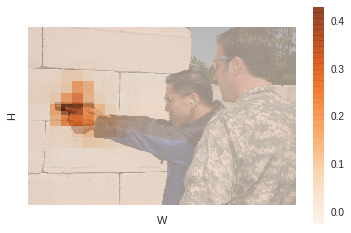

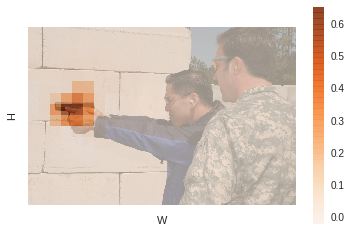

Total time: 0 h  0 m  8.216539859771729 s


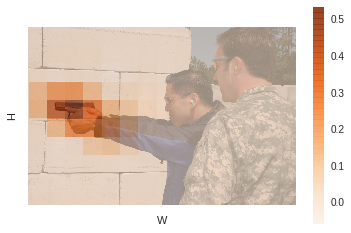

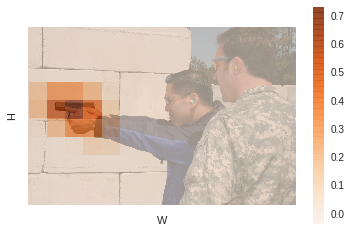

data/occlusion_images/image18.jpg
Total time: 0 h  0 m  18.862878561019897 s


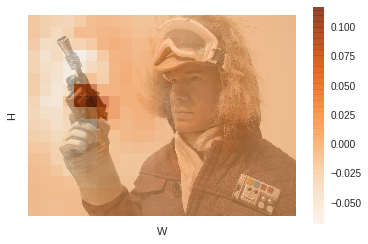

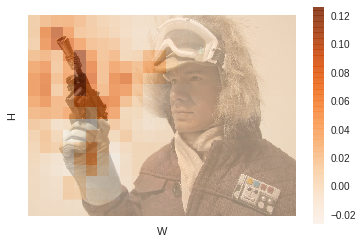

Total time: 0 h  0 m  8.40867805480957 s


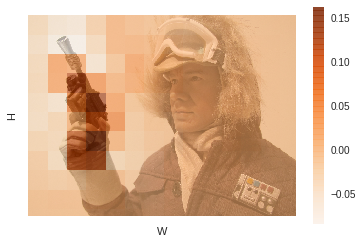

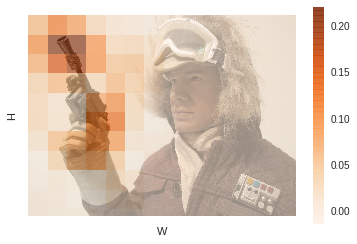

In [0]:
#Specify if you want to print the progress messages
progressPrint = False

with open('data/occlusion_images/nameAndBB.csv') as f:
  reader = csv.reader(f)
  image_info = list(reader)
  
#Iterate over different images
for i in ImgTbIter:
  
  #Specify the path to the image on which the occlusion experiment
  #will be performed.
  image_path = "data/occlusion_images/" + image_info[i][0]
  print(image_path)
  
  #The real_box variable contains the ground truth coordinates
  #real_box = [ymin, xmin, ymax, xmax]
  real_box = image_info[i][1:5]
  real_box = [int(x) for x in real_box]

  #Iterate over size/stride configurations
  for j in ConfTbIter:
    [stride, size] = j
    
    [confidence_map, IoU_map, 
     occlusion_frequency_map, 
     confidence_og, IoU_og, 
     image_np] = occlude_and_infer(
        image_path, real_box, 
        stride, size, progressPrint
    )

    avg_confidence_map = confidence_map/occlusion_frequency_map
    avg_IoU_map = IoU_map/occlusion_frequency_map
    
    #change the directory to the one you want to save the heatmaps in
    #os.chdir('')

    save_heatmaps(
        confidence_og, avg_confidence_map, 
        IoU_og, avg_IoU_map,
        image_np, stride, size, MODEL_TYPE)
    os.chdir("/content/occlusion_experiments/main_content")
    
